In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
from sklearn.cross_validation import train_test_split

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
y = pd.read_csv('triptype.csv', header= None)
X = sparse.load_npz('df_sparse_matrix.npz')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

In [38]:
X_train.shape


(30564, 5275)

In [40]:
from scipy import sparse
sparse.save_npz('X_train.npz', X_train)
sparse.save_npz('X_test.npz', X_test)
np.savetxt("y_train.csv", y_train, delimiter = ",")
np.savetxt("y_test.csv", y_test, delimiter = ",")

## Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
nb = MultinomialNB()

In [35]:
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

In [36]:
error_nb = np.mean(pred_nb[:, np.newaxis] != y_test)
print(error_nb)

0    0.379744
dtype: float64


## Logistic Regression

### Logistic Regression Without tuning

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
lr = LogisticRegression(random_state= 95828)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

In [10]:
error_lr = np.mean(pred_lr[:, np.newaxis] != y_test)
print(error_lr)

0    0.32413
dtype: float64


### Logistic Regression With tuning

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [12]:
parameters = {'C':[1e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100]}
lr_cv = GridSearchCV(LogisticRegression(penalty='l1', random_state= 95828, solver = 'saga', ), cv = StratifiedKFold(n_splits=5, shuffle = True), param_grid = parameters, n_jobs = -1)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=95828, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
pred_lr_cv = lr_cv.predict(X_test)
error_lr_cv = np.mean(pred_lr_cv[:, np.newaxis] != y_test)
print(error_lr_cv)

0    0.321905
dtype: float64


In [14]:
from sklearn.metrics import confusion_matrix

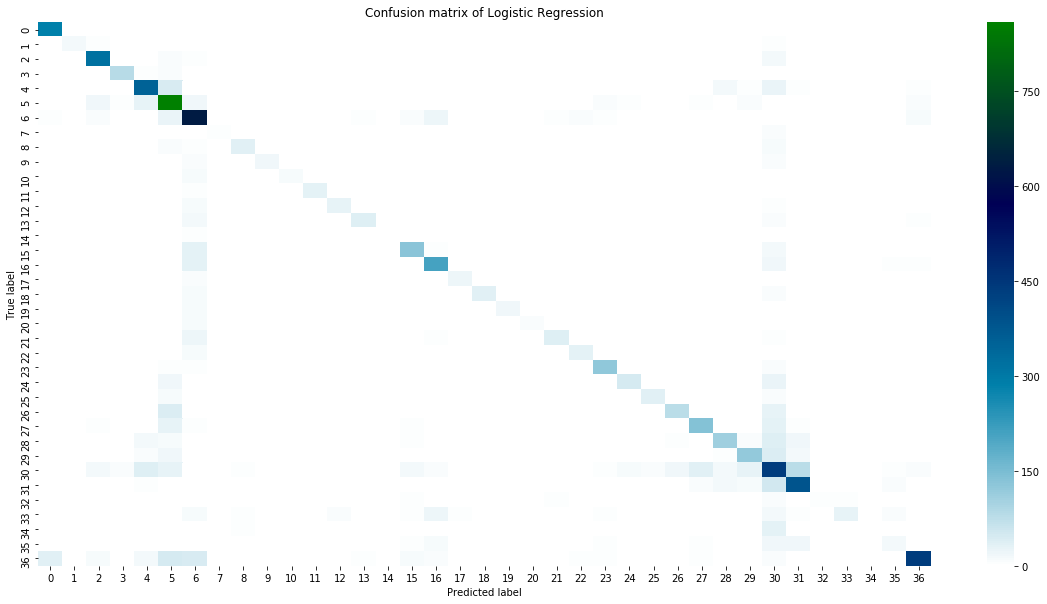

In [15]:
plt.figure(figsize=(20,10))
lr_cm = confusion_matrix(y_test, pred_lr_cv)
sns.heatmap(lr_cm, cmap='ocean_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of Logistic Regression')
plt.show()

## SVM

### SVM Without tuning

In [16]:
from sklearn.svm import LinearSVC

In [17]:
svc = LinearSVC(random_state= 95828)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

In [18]:
error_svc = np.mean(pred_svc[:, np.newaxis] != y_test)
print(error_svc)

0    0.360508
dtype: float64


### SVM With tuning

In [19]:
param_grid={'C': [0.01, 0.1, 1, 10, 100]}
svc_cv = GridSearchCV(LinearSVC(penalty='l2', random_state= 95828), cv = StratifiedKFold(n_splits=5, shuffle = True), param_grid = parameters, n_jobs = -1)
svc_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=95828, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
pred_svc_cv = svc_cv.predict(X_test)
error_svc_cv = np.mean(pred_svc_cv[:, np.newaxis] != y_test)
print(error_svc_cv)

0    0.328186
dtype: float64


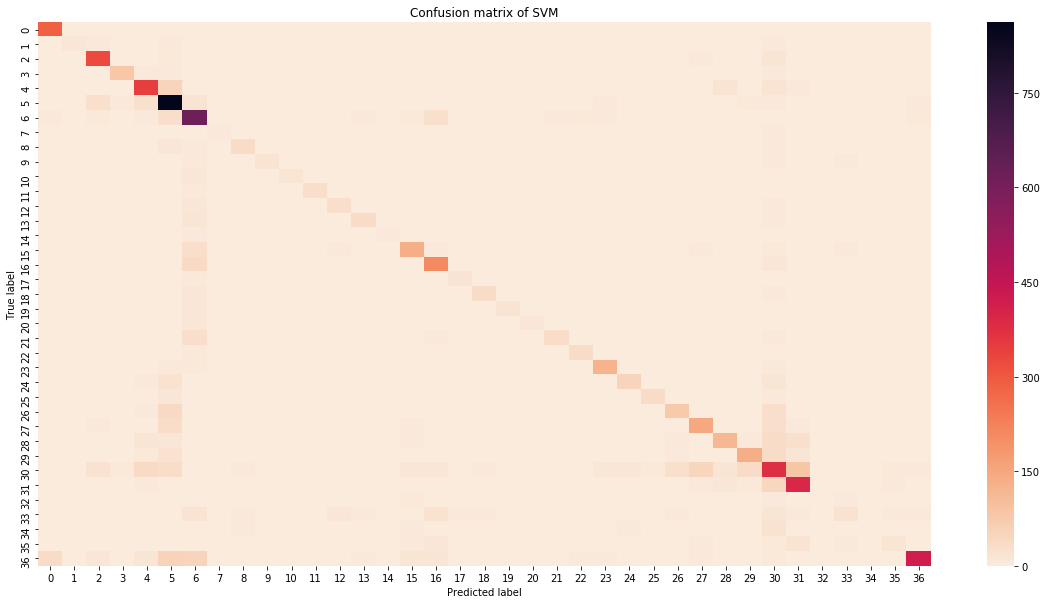

In [21]:
plt.figure(figsize=(20,10))
svm_cm = confusion_matrix(y_test, pred_svc_cv)
sns.heatmap(svm_cm, cmap='rocket_r')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of SVM')
plt.show()